# 06 Scalar Regression

This notebook describes how to perform Scalar regression on images 

Installing the library:

In [ ]:
!pip install fastai -q --upgrade

# Dataset

The dataset is the [IMDB-WIKI](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/) dataset in which we try to guess the expected age from an indivudal image. We'll focus on the WIKI dataset.

In [1]:
from fastai.vision.all import *

In [ ]:
url = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'

In [ ]:
!wget {url}

--2020-08-12 12:39:18--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar         3%[                    ]  25.97M  3.52MB/s    eta 3m 46s ^C


In [ ]:
!tar -xvf 'wiki_crop.tar'

Now the dataset itself is pretty easy, the images are in folders by their age.

In [ ]:
def to_num(x:str): return int(x)

In [ ]:
block = DataBlock(blocks=(ImageBlock, RegressionBlock()),
                  get_items=get_image_files,
                  splitter=RandomSplitter(),
                  get_y=Pipeline([parent_label, to_num]),
                  item_tfms=Resize(460, method='squish'),
                  batch_tfms=[*aug_transforms(size=224, max_warp=0)])

**BUT** we cannot show a batch of this data

In [ ]:
dls = block.dataloaders('')

AttributeError: ignored

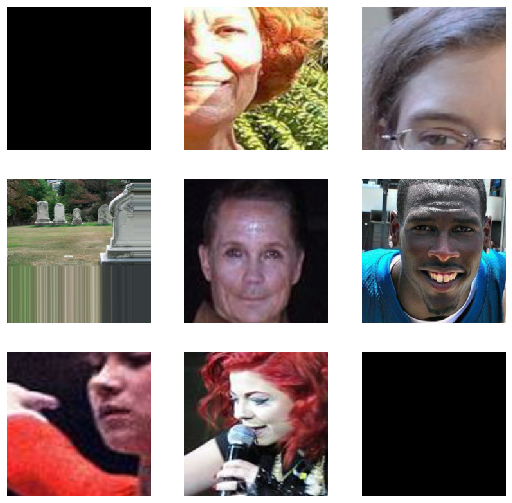

In [ ]:
dls.show_batch()

Let's rework this into a different transform

In [ ]:
class TitledNumberShort(Int, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(f'{self:.2f}', ctx=ctx, **merge(self._show_args, kwargs))

In [ ]:
class ToIntTensor(Transform):
    "Transform to int tensor"
    order = 10 #Need to run after PIL transforms on the GPU
    _show_args = {'label': 'text'}
    def __init__(self, split_idx=None, as_item=True):
        super().__init__(split_idx=split_idx,as_item=as_item)

    def encodes(self, o): return o.int()
    def decodes(self, o): return TitledFloatShort(o)

In [ ]:
block = DataBlock(blocks=(ImageBlock, RegressionBlock()),
                  get_items=get_image_files,
                  splitter=RandomSplitter(),
                  get_y=Pipeline([parent_label, to_num, ToFloatTensor]),
                  item_tfms=Resize(460, method='squish'),
                  batch_tfms=[Flip(), Rotate(), Zoom(), Warp()])

In [ ]:
dls = block.dataloaders('')

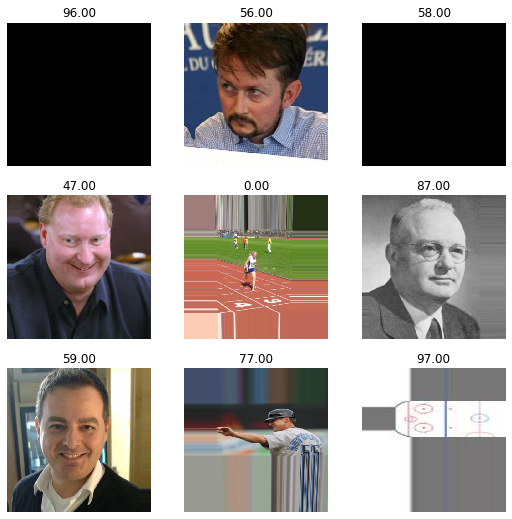

In [ ]:
dls.show_batch()

In [ ]:
dls.c

1

And now we can run this through `cnn_learner`

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=MSELossFlat(), y_range=(0,100))

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,853.149658,833.676636,06:37


In [ ]:
imgs = get_image_files('wiki_crop/50')

In [ ]:
imgs[0]

Path('wiki_crop/50/13079650_1925-01-08_1952.jpg')

In [ ]:
learn.predict(imgs[0])

(47.467430114746094, tensor([47.4674]), tensor([47.4674]))